In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pylab import rcParams

In [2]:
path_to_metada = "../outputs/2021-01-27/plt_onewindow_3k/plt_test_win_20/projector/add_8vector_kmeans_scalar_labels/metadata.tsv"
path_to_spherizedata = "../visualize3d/tmp/state_2021-01-27_plt_onewindow_3k_plt_test_win_20.txt"

In [3]:
def parse_txt(path_to_pcadata):
    with open(path_to_pcadata) as f:
        json_dict = json.load(f)[0]

    #pprint.pprint(json_dict.keys(), width=40)
    #print(len(json_dict["projections"]))

    df = pd.json_normalize(json_dict["projections"])
    slice_dimensions = json_dict["pcaComponentDimensions"]
    df = df.iloc[:, slice_dimensions]
    return df
df_spherizedata = parse_txt(path_to_spherizedata)
df = pd.read_csv(path_to_metada, sep="\t")


In [4]:
df.columns, df_spherizedata.columns

(Index(['Time', 'Date',
        'ShapePrev_ShapeNext_PrevContShapeNow_NextContShapeNow_ContShapeNow',
        '8vector_label', 'vector_scalar', 'kmeans'],
       dtype='object'),
 Index(['pca-0', 'pca-1', 'pca-2'], dtype='object'))

In [5]:
print("8vector_label: {}".format(set(df["8vector_label"])))
print("kmeans: {}".format(set(df["kmeans"])))
print("Vecotr: {}<{}".format(df["vector_scalar"].min(), df["vector_scalar"].max()))


8vector_label: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, -1.0}
kmeans: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Vecotr: 0.0<1.913792301353632


In [34]:
thres = 0.3
array_scale = 0.3

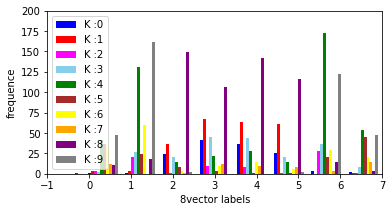

In [8]:
tmp = []
labels = []
colors = []
color_dict = {
    0: "blue",
    1: "red",
    2: "magenta",
    3: "skyblue",
    4: "green",
    5: "brown",
    6: "yellow",
    7: "orange",
    8: "purple",
    9: "gray",
}
for kmeans_labels in set(df["kmeans"]):
    df_k = df[df["kmeans"]==kmeans_labels]
    df_k_thres = df_k[df_k["vector_scalar"]<thres]
    tmp.append(df_k_thres.loc[:, "8vector_label"])
    labels.append("K :{}".format(kmeans_labels))
    colors.append(color_dict[kmeans_labels])
rcParams["figure.figsize"]= 6, 3
plt.hist(tmp, bins=9, label=labels, color=colors)
#plt.title("kmeans:{}".format(kmeans_labels))
plt.ylabel("frequence")
plt.xlabel("8vector labels")
plt.xlim(-1, 7)
plt.ylim(0, 200)
plt.legend()
plt.show()

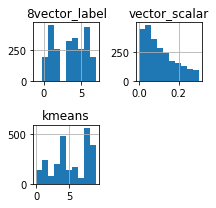

In [9]:
rcParams["figure.figsize"]= 3, 3
df[df["vector_scalar"]<thres].iloc[:, -3:].hist()
plt.tight_layout()
plt.show()

３D矢印を書きたい

In [10]:
%matplotlib inline

In [35]:
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
import matplotlib.animation as animation
import itertools

def plt_3dvector(ax, loc, v, length, color):
    ax.quiver(loc[0], loc[1], loc[2], v[0], v[1], v[2], length=length, color=color)

def plt_8vector(ax, loc, length_list, color):
    # edge of cube
    # group = [-1, 1]
    # v = list(itertools.product(group, group, group))
    Vector = {
        "000": [-1 * array_scale, -1 * array_scale, -1 * array_scale],
        "001": [-1 * array_scale, -1 * array_scale, +1 * array_scale],
        "010": [-1 * array_scale, +1 * array_scale, -1 * array_scale],
        "011": [-1 * array_scale, +1 * array_scale, +1 * array_scale],
        "100": [+1 * array_scale, -1 * array_scale, -1 * array_scale],
        "101": [+1 * array_scale, -1 * array_scale, +1 * array_scale],
        "110": [+1 * array_scale, +1 * array_scale, -1 * array_scale],
        "111": [+1 * array_scale, +1 * array_scale, +1 * array_scale],
        }
    name_8vector = list(length_list.keys())
    print("name_8vector: ", name_8vector)
    Freq = {}

    print("length_list: ", max(length_list.values()), min(length_list.values()))
    length_list_max, length_list_min = max(length_list.values()), min(length_list.values())

    for name_ in name_8vector:
        #Freq={
        #   "000": length_list[0.0] * 0.01
        # }
        if name_ == -1.0:
            continue
        # norm
        normed_freq = ((length_list[name_] - length_list_min) / (length_list_max - length_list_min))
        Freq["{:03b}".format(int(name_))] = normed_freq

        # not norm
        #Freq["{:03b}".format(int(name_))] = length_list[name_] * (1/200)

    print("Freq max, min", max(Freq.values()), min(Freq.values()))
    for key in Freq.keys():
        v_i = Vector[key]
        length_i = Freq[key]
        plt_3dvector(ax, loc, v_i, length_i, color)



In [12]:
def plt_3darrows(locs, length_lists, colors, data_for_scatter, kmeans_color, save_path="./rotate.gif"):
    """
    Args:
        locs: Kmeansのクラスタ中心（代表点をサンプリング）の座標
            [[0, 0, 0], [0.5, 0.5, 0.5]]

        length_lists: 仮ラベルの頻度
            [[1.0 for i in range(0, 8, 1)], [1.0 for i in range(0, 8, 1)]]

        colors: Kmeansのクラスタの色
            ["blue", "red"]

        data_for_scatter: 全データ点
    """

    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection="3d")

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    x = data_for_scatter.iloc[:, 0].values
    y = data_for_scatter.iloc[:, 1].values
    z = data_for_scatter.iloc[:, 2].values

    ax.scatter(x, y, z, alpha=0.3, c=kmeans_color, s=2)

    def init():
        for (k_of_kmeans, loc), (k_of_kmeans2, length_list), color in zip(locs.items(), length_lists.items(), colors):
            print((k_of_kmeans, loc), (k_of_kmeans2, length_list), color)
            plt_8vector(ax, loc, length_list, color)
        return fig,
    def animate(i):
        ax.view_init(30, 3.6*i)
        return fig,

    # Animate
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=100, interval=100, blit=True)
    file_format = save_path.split(".")[-1]
    writer = {
        "gif":"imagemagick",
        "mp4":"ffmpeg"
    }
    ani.save(save_path, writer=writer[file_format],dpi=100)


In [13]:
def cluster_locs(df, df_spherizedata, thres):
    """Kmeansクラスタの平均座標
    """
    df_tmp = pd.concat([df_spherizedata, df], axis=1)
    locs = {}
    for kmeans_labels in set(df_tmp["kmeans"]):
        df_k = df_tmp[df_tmp["kmeans"]==kmeans_labels]
        df_k_thres = df_k[df_k["vector_scalar"]<thres]
        loc_xyz = df_k_thres.iloc[:, :3].mean().values
        locs[kmeans_labels] = list(loc_xyz)

    return locs
cluster_locs(df, df_spherizedata, thres)

{0: [-0.6970509264204238, -0.6525314975667883, -0.09295548848178306],
 1: [0.47151450163278824, 0.8471808122773455, -0.0658289158421282],
 2: [0.6935034511057107, 0.015705896950503055, 0.6225702919670053],
 3: [-0.07249346450270883, -0.9522433992069547, -0.08860845754089036],
 4: [-0.958151858932567, 0.2077706870840754, -0.0011206582866231296],
 5: [0.8695680333035333, -0.33704623187825616, -0.2194665316093181],
 6: [-0.22212938858482803, 0.9454792290064641, -0.04497956618871217],
 7: [-0.1949893674949029, -0.6271965389450391, 0.6691970522205035],
 8: [0.8887234745603619, 0.4072037372777966, -0.013195289766420934],
 9: [-0.7668401274588201, 0.61526859038836, 0.005102946065924155]}

In [14]:
def frequent_lists(df, thres):
    """仮ラベル毎の8vectorの頻度
    """
    length_lists = {}
    for kmeans_labels in set(df["kmeans"]):
        df_k = df[df["kmeans"]==kmeans_labels]
        df_k_thres = df_k[df_k["vector_scalar"]<thres]
        tmp = dict(df_k_thres["8vector_label"].value_counts())
        length_lists[kmeans_labels] = tmp
    return length_lists
#frequent_lists()


MovieWriter imagemagick unavailable; using Pillow instead.
(0, [-0.6970509264204238, -0.6525314975667883, -0.09295548848178306]) (0, {3.0: 42, 4.0: 36, 5.0: 26, 2.0: 24, 6.0: 3, 7.0: 2, 1.0: 1, 0.0: 1}) blue
name_8vector:  [3.0, 4.0, 5.0, 2.0, 6.0, 7.0, 1.0, 0.0]
length_list:  42 1
Freq max, min 1.0 0.0
(1, [0.47151450163278824, 0.8471808122773455, -0.0658289158421282]) (1, {3.0: 67, 4.0: 63, 5.0: 61, 2.0: 36, 0.0: 3, 1.0: 3, 7.0: 1}) red
name_8vector:  [3.0, 4.0, 5.0, 2.0, 0.0, 1.0, 7.0]
length_list:  67 1
Freq max, min 1.0 0.0
(2, [0.6935034511057107, 0.015705896950503055, 0.6225702919670053]) (2, {6.0: 28, 1.0: 21, 3.0: 10, 4.0: 8, 0.0: 4, 7.0: 1, 5.0: 1, 2.0: 1}) magenta
name_8vector:  [6.0, 1.0, 3.0, 4.0, 0.0, 7.0, 5.0, 2.0]
length_list:  28 1
Freq max, min 1.0 0.0
(3, [-0.07249346450270883, -0.9522433992069547, -0.08860845754089036]) (3, {3.0: 45, 4.0: 44, 6.0: 36, 1.0: 27, 2.0: 20, 5.0: 20, 7.0: 8, 0.0: 2}) skyblue
name_8vector:  [3.0, 4.0, 6.0, 1.0, 2.0, 5.0, 7.0, 0.0]
length_l

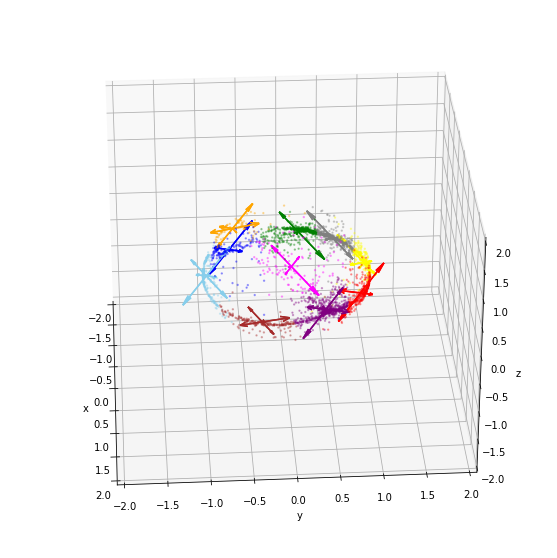

In [36]:
# Examples
#locs = [[0, 0, 0], [0.5, 0.5, 0.5]]
#length_lists = [[1.0 for i in range(0, 8, 1)], [1.0 for i in range(0, 8, 1)]]
#colors = ["blue", "red"]

# Worm2vec
locs = cluster_locs(df, df_spherizedata, thres)
length_lists = frequent_lists(df, thres)
data_for_scatter = df_spherizedata.iloc[:, :3]
kmeans_color = df.loc[:, "kmeans"].replace(color_dict)
plt_3darrows(locs, length_lists, colors, data_for_scatter, kmeans_color, save_path="./rotate_norm.gif")

In [18]:
df.describe()

,0,1,2,Time,Date,ShapePrev_ShapeNext_PrevContShapeNow_NextContShapeNow_ContShapeNow,8vector_label,vector_scalar,kmeans
count,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.0,3000.000000,3000.000000,3000.000000
mean,54.718379,-23.929296,-155.345337,1504.500000,2.013022e+11,0.0,3.499333,0.188822,5.223667
std,82.737181,22.486510,68.446663,866.169729,0.000000e+00,0.0,2.190799,0.226651,2.908343
min,-316.354095,-127.325798,-350.322144,5.000000,2.013022e+11,0.0,-1.000000,0.000000,0.000000
25%,14.571592,-34.221854,-208.452030,754.750000,2.013022e+11,0.0,1.000000,0.048302,3.000000
50%,72.699379,-25.502417,-162.056801,1504.500000,2.013022e+11,0.0,4.000000,0.112559,5.000000
75%,114.010574,-12.025466,-106.999531,2254.250000,2.013022e+11,0.0,6.000000,0.241641,8.000000
max,208.741257,51.521080,-6.231232,3004.000000,2.013022e+11,0.0,7.000000,1.913792,9.000000
